In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install netCDF4

In [5]:
import os
import sys
DRIVE_ROOT = "/content/drive/MyDrive/DynamicsTensors"
REPO_ROOT  = f"{DRIVE_ROOT}/bstt2"
DATA_DIR   = f"{DRIVE_ROOT}/data"
OUT_DIR    = f"{DRIVE_ROOT}/outputs"

EXP = "basetests"
RUN_DIR = f"{OUT_DIR}/{EXP}"

os.makedirs(RUN_DIR, exist_ok=True)
if REPO_ROOT not in sys.path: sys.path.append(REPO_ROOT)

print("Repo:", REPO_ROOT)
print("Data:", DATA_DIR)
print("Run dir:", RUN_DIR)
train_path = os.path.join(DATA_DIR, "train_data.e")
test_path  = os.path.join(DATA_DIR, "test_data_2.e")

from utils import name_scan, inspect_fields, load_fields, Dataset, chartostring, plot_flow_snapshot, plot_heatmap_contours

Repo: /content/drive/MyDrive/DynamicsTensors/bstt2
Data: /content/drive/MyDrive/DynamicsTensors/data
Run dir: /content/drive/MyDrive/DynamicsTensors/outputs/basetests


In [6]:
# Uploading orginal bsst modules
from misc import  __block, sinecosine_measures, random_homogenous_polynomial_sum_system2,random_fixed_variable_sum_system2,legendre_measures
from helpers import fermi_pasta_ulam,fermi_pasta_ulam2,SMat
from als import ALSSystem2
from bstt import Block, BlockSparseTensor, BlockSparseTT
block = __block()
######################
# Import Standard libs
from time import time as clock
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.tri as mtri
from utils import name_scan, inspect_fields, load_fields, Dataset, chartostring, plot_flow_snapshot, plot_heatmap_contours


In [7]:
train_path = os.path.join(DATA_DIR, "train_data.e")
test_path  = os.path.join(DATA_DIR, "test_data_2.e")
print("format:", name_scan(train_path))
###################################################
meta = inspect_fields(train_path)
print(meta)
times, coordx, coordy, Vx, Vy, P, V_stack = load_fields(train_path, t_start=0, t_count=None)
stride = 10
idx = np.arange(0, coordx, stride)

coordx = coordx[idx]
coordy = coordy[idx]
Vx = Vx[idx, :]
Vy = Vy[idx, :]
V_stack = V_stack[idx,]


print("shape times:", times.shape)
print("shape coords:", coordx.shape, coordy.shape)
print("shape Vx/Vy/P:", Vx.shape, Vy.shape, P.shape)
print("shape V_stack:", V_stack.shape)

format: exodus
{'format': 'exodus', 'num_nodes': 6569, 'num_elems': 6384, 'time_steps': 5541, 'nodal_var_names': ['V_y', 'V_x', 'P'], 'time_key_guess': 'time_whole'}
shape times: (5541,)
shape coords: (657,) (657,)
shape Vx/Vy/P: (657, 5541) (657, 5541) (6569, 5541)
shape V_stack: (657, 5541)


In [8]:
coordx.shape[0]

657

In [6]:
# Velocities vector fields extracted, data is stucked in V = [Vx,Vy,T].
# Culculating difference ( extremely simple)
dV_stack = np.diff(V_stack, axis = 1)
dV_x = dV_stack[0:Vx.shape[0],:]
dV_y = dV_stack[Vx.shape[0] : Vx.shape[0] + Vy.shape[0],:]

# Test Data:
times_t, x_t, y_t, Vx_t, Vy_t, P_t, V_stack_t = load_fields(test_path, t_start=0, t_count=5541)
print(times_t.shape, Vx_t.shape, Vy_t.shape, P_t.shape, V_stack_t.shape)
dV_stack_t= np.diff(V_stack_t, axis = 1)
dV_x_t = dV_stack_t[0:Vx_t.shape[0],:]
dV_y = dV_stack_t[Vx_t.shape[0] : Vx_t.shape[0] + Vy_t.shape[0],:]

(1409,) (6569, 1409) (6569, 1409) (6569, 1409) (13138, 1409)


In [7]:
def plot_vector_field(Fx,Fy, path, t_index=0, quiver_frac=0.03, probe_node=None):
    ds = Dataset(path, "r")
    x = ds.variables["coordx"][:]
    y = ds.variables["coordy"][:]

    conn_keys = [k for k in ds.variables.keys() if k.startswith("connect")]
    assert conn_keys, "No connectivity array ('connect*') found."
    conn = np.asarray(ds.variables[conn_keys[0]][:], dtype=int) - 1
    if conn.shape[1] == 3:
        tri_conn = conn
    elif conn.shape[1] == 4:
        tri_conn = np.vstack([conn[:, [0, 1, 2]],
                              conn[:, [0, 2, 3]]])
    else:
        raise ValueError(f"Unsupported element with {conn.shape[1]} nodes (expected 3 or 4).")
    tri = mtri.Triangulation(x, y, triangles=tri_conn)

    # Snapshot
    Vy_t = Fy[:,t_index]
    Vx_t = Fx[:,t_index]
    magnitude = np.sqrt(Vx_t**2 + Vy_t**2)

    # Downsample for quiver
    n = x.size
    step = max(1, int(round(1.0 / max(quiver_frac, 1e-6))))
    q_idx = np.arange(0, n, step)

    # Figure: heatmap (|V|) + quiver
    fig, ax = plt.subplots(figsize=(15, 10))
    # Heatmap on unstructured mesh
    tpc = ax.tripcolor(tri, magnitude, shading="gouraud")
    cb = plt.colorbar(tpc, ax=ax, shrink=0.9, label="|F|")
    # Quiver on top
    ax.quiver(
        x[q_idx], y[q_idx], Vx_t[q_idx], Vy_t[q_idx],
        angles="xy", scale_units="xy", scale=1, width=0.002,
        alpha=0.9, zorder=3
    )
    ax.set_aspect("equal", adjustable="box")
    ax.set_title(f"{os.path.basename(path)} | t={t_index}")
    ax.set_xlabel("x"); ax.set_ylabel("y")
    fig.tight_layout()
    plt.show()

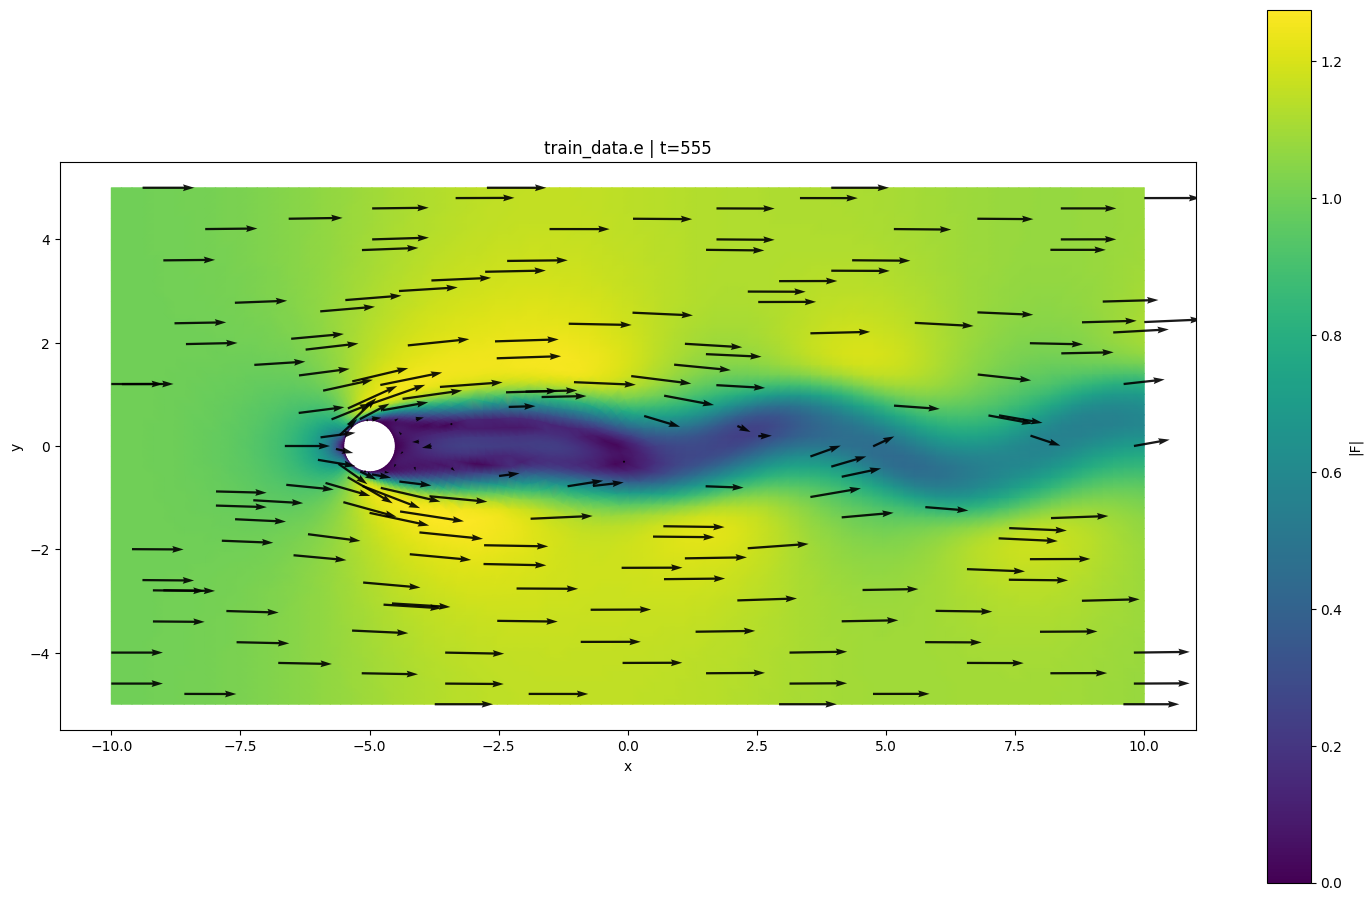

In [8]:
plot_vector_field(Vx,Vy,train_path,  t_index=555)

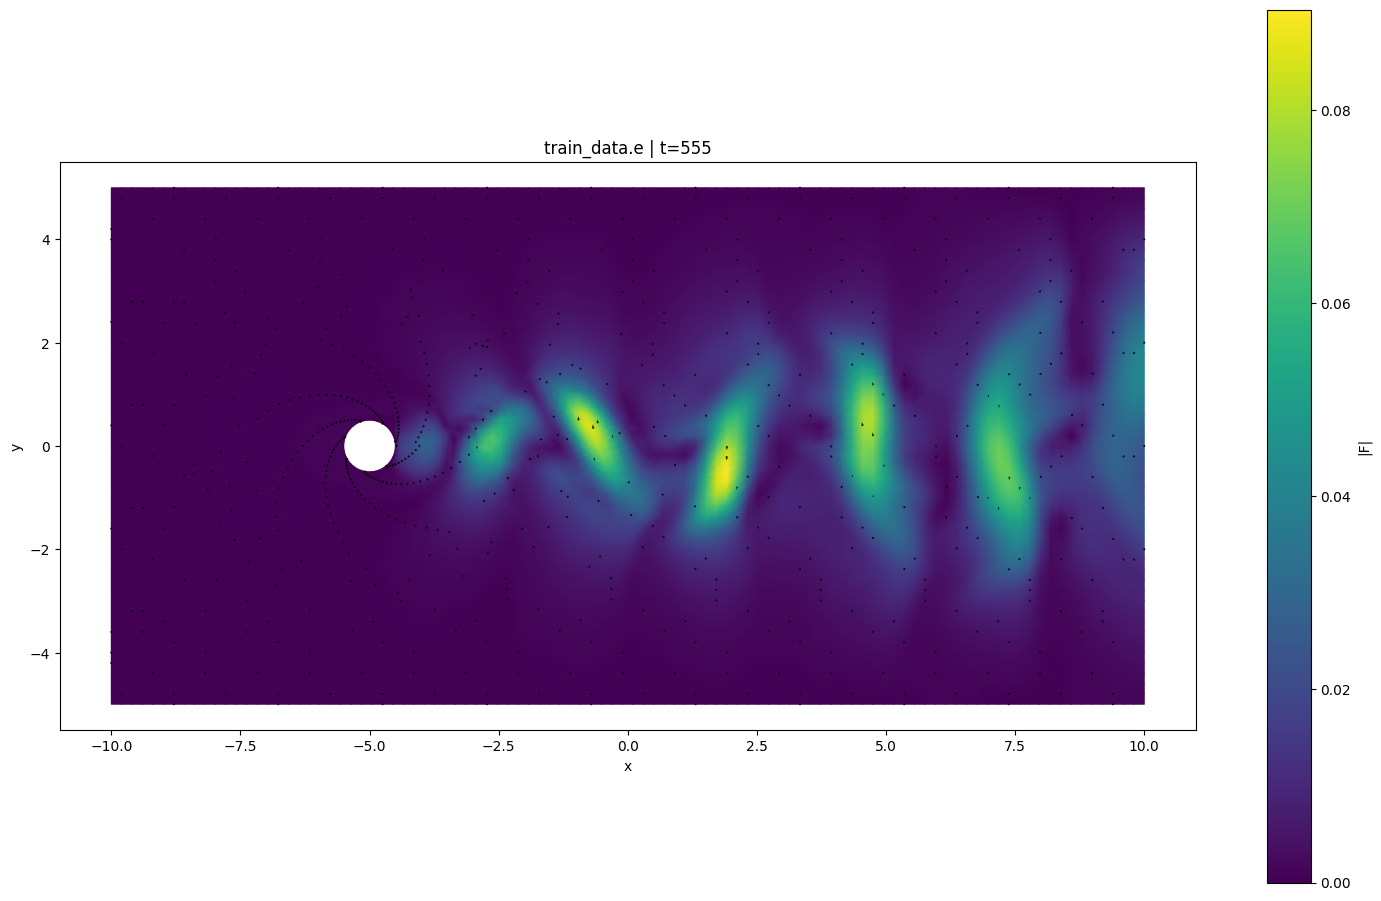

In [9]:
plot_vector_field(dV_x,dV_y,train_path, t_index=555,  quiver_frac=0.1)

### Dynmaics Extraction via BlockSparseTT

In [10]:
# CONFIGURATION:
order =  13138 # Physical dimension in the paper
degree = 2  # [p0,p1,p2,p3] - degree of funciton from dictionary
maxGroupSize = 2
interaction = 3
#interaction = [2]*order
trainSampleSize = [400]
maxSweeps=10
ranks = [4]*(order-1)
targetResidual = 1e-6
trainSampleSizes =  [400]
testSampleSize = 200
seed_global = 123
###############################################################################

In [11]:
def build_measures(points, degree, add_constant_mode=True):
    """
    Build Legendre dict values per coordinate and optionally append a constant mode.
    points: (N, order)
    Returns:
        measures: (order + add_constant, N, degree+1)
    """
    # legendre_measures expects shape (N, M) and returns (M, N, degree+1)
    measures = legendre_measures(points, degree)  # (order, N, degree+1)
    if add_constant_mode:
        ones_row = np.ones((1, points.shape[0], degree + 1))
        measures = np.concatenate([measures, ones_row], axis=0)  # (order+1, N, degree+1)
    return measures


In [12]:
measures = build_measures(V_stack, degree = degree)
measures.shape

(5542, 13138, 3)

In [15]:
def build_measures(points, degree):
    """
    Build Legendre dict values per coordinate and optionally append a constant mode.
    points: (N, order)
    Returns:
        measures: (order + add_constant, N, degree+1)
    """
    measures = legendre_measures(points, degree)
    return measures


def build_model(order, degree, maxGroupSize, interaction, selection_matrix=None):
    """
    Create a BlockSparseTTSystem2 model with degree-banded blocks and interaction gating.
    System2 expects an integer selection matrix of shape (D, order) where
    D = number of equations (=order here) and 'order' is the number of TT cores
    (we use order+1 measures; the extra constant mode is handled by the TT builder)
    """
    S = selection_matrix if selection_matrix is not None else SMat(interaction, order)
    bstt = random_homogenous_polynomial_sum_system2(
        _univariateDegrees=[degree] * order,
        _totalDegree=degree,
        _maxGroupSize=maxGroupSize,
        _numberOfInteractions=interaction,
        _selectionMatrix=S,
    )
    return bstt


def fit_model(bstt, measures, targets, maxSweeps, targetResidual, maxGroupSize, verbosity=1):
    """
    Wrap ALSSystem2 with already-augmented measures.
    measures: (order+1, N_samples, degree+1)
    targets:  (N_samples, order)
    """
    solver = ALSSystem2(bstt, measures, targets, _verbosity=verbosity)
    solver.maxSweeps = maxSweeps
    solver.targetResidual = targetResidual
    solver.maxGroupSize = maxGroupSize
    solver.run()
    return bstt, solver
# Evaluation
def rel_L2(pred, truth):
    """Relative L2 error"""
    return np.linalg.norm(pred - truth) / np.linalg.norm(truth)
def evaluate_model(bstt, measures_train, y_train, measures_test, y_test):
    """
    Evaluate on train & test measures/targets.
    Returns (err_train, err_test)
    """
    ytr_hat = bstt.evaluate(measures_train)
    yte_hat = bstt.evaluate(measures_test)
    return rel_L2(ytr_hat, y_train), rel_L2(yte_hat, y_test)

def run_learning_curve(
    states_full,    # (N_total, order) = points
    derivs_full,    # (N_total, order) = values
    states_test,    # (N_test_total, order)
    derivs_test,    # (N_test_total, order)
    order,
    degree,
    maxGroupSize,
    interaction,
    trainSampleSizes,
    testSampleSize,
    maxSweeps,
    targetResidual,
    seed=123,
    verbose=1,
):
    results = []

    # select test set
    N_test = min(testSampleSize, states_test.shape[0])
    test_points  = states_test[:N_test, :]
    test_values  = derivs_test[:N_test, :]

    test_measures = build_measures(test_points, degree)   # (order, N_test, degree+1)
    augmented_test_measures = np.concatenate(
        [test_measures, np.ones((1, N_test, degree+1))],
        axis=0
    )

    for N_samples_train in trainSampleSizes:
        if verbose:
            print(f"\n=== Training with N={N_samples_train} samples ===")

        train_points = states_full[:N_samples_train, :]   # (N_train, order)
        train_values = derivs_full[:N_samples_train, :]   # (N_train, order)

        train_measures = build_measures(train_points, degree) # (order, N_train, degree+1)
        augmented_train_measures = np.concatenate(
            [train_measures, np.ones((1, N_samples_train, degree+1))],
            axis=0
        )

        # model
        S    = SMat(interaction, order)
        bstt = random_homogenous_polynomial_sum_system2(
            _univariateDegrees=[degree]*order,
            _totalDegree=degree,
            _maxGroupSize=maxGroupSize,
            _numberOfInteractions=interaction,
            _selectionMatrix=S,
        )

        if verbose:
            print(f"DOFS: {bstt.dofs()}")
            print(f"Ranks: {bstt.ranks}")
            print(f"Interaction: {bstt.interactions}")

        # train
        bstt, solver = fit_model(
            bstt,
            augmented_train_measures,
            train_values,
            maxSweeps=maxSweeps,
            targetResidual=targetResidual,
            maxGroupSize=maxGroupSize,
            verbosity=1 if verbose else 0,
        )

        # evaluate
        values_tr_hat = bstt.evaluate(augmented_train_measures)
        values_te_hat = bstt.evaluate(augmented_test_measures)

        err_tr = rel_L2(values_tr_hat, train_values)
        err_te = rel_L2(values_te_hat, test_values)

        if verbose:
            print(f"L2 (test): {err_te:.3e} | L2 (train): {err_tr:.3e}")

        results.append({
            "N": int(N_samples_train),
            "L2_train": float(err_tr),
            "L2_test": float(err_te),
            "DOFS": int(bstt.dofs()),
            "ranks": list(bstt.ranks),
            "interaction": int(bstt.interactions),
        })

    return results


In [ ]:
# V_stack: (d, T)
# V_stack_t: (d, T_test)
dt = times[1] - times[0]   # or 1.0 if you just care about relative errors

# forward difference -> size T-1
states_full  = V_stack.T[:-1, :]                       # (T-1, d)
derivs_full  = (V_stack.T[1:, :] - V_stack.T[:-1, :]) / dt   # (T-1, d)

states_test  = V_stack_t.T[:-1, :]                     # (T_test-1, d)
derivs_test  = (V_stack_t.T[1:, :] - V_stack_t.T[:-1, :]) / dt
order = states_full.shape[1]


results = run_learning_curve(
    states_full, derivs_full,
    states_test, derivs_test,
    order=order,
    degree=degree,
    maxGroupSize=maxGroupSize,
    interaction=interaction,
    trainSampleSizes=trainSampleSizes,
    testSampleSize=testSampleSize,
    maxSweeps=maxSweeps,
    targetResidual=targetResidual,
    seed=123,
    verbose=1,
)

print("\nN\tL2_train\tL2_test\tDOFS\tRanks")
for r in results:
    print(f"{r['N']}\t{r['L2_train']:.3e}\t{r['L2_test']:.3e}\t{r['DOFS']}\t{r['ranks']}")


=== Training with N=400 samples ===
DOFS: 433521
Ranks: [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 